In [102]:
import scipy as sp

In [98]:
import numpy as np
from numpy import random
import pandas as pd
from extrapolate_production_data import ProductionData
from Carbon_tariffs import TariffData
from sklearn.model_selection import ParameterGrid
import seaborn as sns
import matplotlib.pyplot as plt

# Import data
## Trade data
trade_flows_country = pd.read_csv("Data/trade_flow_data_all_country.csv")
trade_flows_total = pd.read_csv("Data/trade_flow_data_total.csv")

### Get income levels of countries
income_level_Data = pd.read_csv("Data/country_level.csv")[
    ["country_name", "income_id"]
]
income_level_Data.loc[
    income_level_Data["country_name"] == "Bosnia and Herzegovina",
    "country_name",
] = "Bosnia-Herzegov"
income_level_Data.loc[
    income_level_Data["country_name"] == "Myanmar", "country_name"
] = "Burma"
income_level_Data.loc[
    income_level_Data["country_name"] == "Dominican Republic", "country_name"
] = "Dominican Rep"
income_level_Data.loc[
    income_level_Data["country_name"] == "Egypt, Arab Rep.", "country_name"
] = "Egypt"
income_level_Data.loc[
    income_level_Data["country_name"] == "Hong Kong SAR, China", "country_name"
] = "Hong Kong"
income_level_Data.loc[
    income_level_Data["country_name"] == "Lao PDR", "country_name"
] = "Laos"
income_level_Data.loc[
    income_level_Data["country_name"] == "Russian Federation", "country_name"
] = "Russia"
income_level_Data.loc[
    income_level_Data["country_name"] == "Slovak Republic", "country_name"
] = "Slovakia"
income_level_Data.loc[
    income_level_Data["country_name"] == "Korea, Rep.", "country_name"
] = "South Korea"
income_level_Data.loc[
    income_level_Data["country_name"] == "United Arab Emirates", "country_name"
] = "United Arab Em"
income_level_Data.loc[
    income_level_Data["country_name"] == "Venezuela, RB", "country_name"
] = "Venezuela"

trade_flows_country = pd.merge(
    trade_flows_country,
    income_level_Data,
    how="left",
    left_on="Country",
    right_on="country_name",
)
trade_flows_country.loc[
    trade_flows_country["Country"] == "Taiwan", "income_id"
] = "HIC"

## Carbon tariff data
R = TariffData().get_mean_price()

## Emission data
C_US = ProductionData().get_gwp(product_type="Plastic").to_list()[0]
C_world = C_US * ProductionData().get_ghg_index("world")
C1_US = ProductionData().get_gwp(product_type="Alternative").to_list()[0]
C1_world = C1_US * ProductionData().get_ghg_index("world")

C_IN = C_US * ProductionData().get_ghg_index("india")
C_CN = C_US * ProductionData().get_ghg_index("china")
C_DE = C_US * ProductionData().get_ghg_index("germany")

C1_IN = C1_US * ProductionData().get_ghg_index("india")
C1_CN = C1_US * ProductionData().get_ghg_index("china")
C1_DE = C1_US * ProductionData().get_ghg_index("germany")

P_US = 0.01 * 1000
P_PAP_US = 0.02 * 1000
P_TEX_US = 0.1 * 1000

trade_flows_country = trade_flows_country.rename(columns ={'qty_in_thousands':'qty_thousands'})
trade_flows_total = trade_flows_total.rename(columns ={'qty_in_thousands':'qty_thousands'})

# Aggregate data by income levels
pd.DataFrame(
    trade_flows_country.loc[
        (trade_flows_country["product"] == "plastic bag")
        & (trade_flows_country["income_id"].isin(["LMC", "LIC"])),
    ]
    .groupby(["Year"])
    .agg(sum_qty_thousands=pd.NamedAgg(column="qty_thousands", aggfunc=sum))
)
# Three-country model
## 14 unknowns: P_LIC, P1_LIC, P_MIC, P1_MIC, P_HIC, P1_HIC, P_DOM, P1_DOM, Q_LIC, Q1_LIC, Q_MIC, Q1_MIC, Q_HIC, Q1_HIC
## Eight parameters: P_US, P1_US, Q_IN, Q1_IN, Q_CN, Q1_CN, Q_DE, Q1_DE, R, C_IN, C1_IN, C_CN, C1_CN, C_DE, C1_DE, e1, e2, eta1, eta2

# Stuff below needs to change to include all countries
Q_US = trade_flows_total.loc[
    (trade_flows_total["product"] == "plastic bag"),
    "qty_thousands",
].to_list()

Q_IN = pd.DataFrame(
    trade_flows_country.loc[
        (trade_flows_country["product"] == "plastic bag")
        & (trade_flows_country["income_id"].isin(["LMC", "LIC"])),
    ]
    .groupby(["Year"])
    .agg(sum_qty_thousands=pd.NamedAgg(column="qty_thousands", aggfunc=sum))
)["sum_qty_thousands"].tolist()

Q_PAP_IN = pd.DataFrame(
    trade_flows_country.loc[
        (trade_flows_country["product"] == "paper bag")
        & (trade_flows_country["income_id"].isin(["LMC", "LIC"])),
    ]
    .groupby(["Year"])
    .agg(sum_qty_thousands=pd.NamedAgg(column="qty_thousands", aggfunc=sum))
)["sum_qty_thousands"].tolist()

Q_TEX_IN = pd.DataFrame(
    trade_flows_country.loc[
        (trade_flows_country["product"] == "textile bag")
        & (trade_flows_country["income_id"].isin(["LMC", "LIC"])),
    ]
    .groupby(["Year"])
    .agg(sum_qty_thousands=pd.NamedAgg(column="qty_thousands", aggfunc=sum))
)["sum_qty_thousands"].tolist()

Q_CN = pd.DataFrame(
    trade_flows_country.loc[
        (trade_flows_country["product"] == "plastic bag")
        & (trade_flows_country["income_id"] == "UMC"),
    ]
    .groupby(["Year"])
    .agg(sum_qty_thousands=pd.NamedAgg(column="qty_thousands", aggfunc=sum))
)["sum_qty_thousands"].tolist()

Q_PAP_CN = pd.DataFrame(
    trade_flows_country.loc[
        (trade_flows_country["product"] == "paper bag")
        & (trade_flows_country["income_id"] == "UMC"),
    ]
    .groupby(["Year"])
    .agg(sum_qty_thousands=pd.NamedAgg(column="qty_thousands", aggfunc=sum))
)["sum_qty_thousands"].tolist()

Q_TEX_CN = pd.DataFrame(
    trade_flows_country.loc[
        (trade_flows_country["product"] == "textile bag")
        & (trade_flows_country["income_id"] == "UMC"),
    ]
    .groupby(["Year"])
    .agg(sum_qty_thousands=pd.NamedAgg(column="qty_thousands", aggfunc=sum))
)["sum_qty_thousands"].tolist()

Q_DE = pd.DataFrame(
    trade_flows_country.loc[
        (trade_flows_country["product"] == "plastic bag")
        & (trade_flows_country["income_id"] == "HIC"),
    ]
    .groupby(["Year"])
    .agg(sum_qty_thousands=pd.NamedAgg(column="qty_thousands", aggfunc=sum))
)["sum_qty_thousands"].tolist()

Q_PAP_DE = pd.DataFrame(
    trade_flows_country.loc[
        (trade_flows_country["product"] == "paper bag")
        & (trade_flows_country["income_id"] == "HIC"),
    ]
    .groupby(["Year"])
    .agg(sum_qty_thousands=pd.NamedAgg(column="qty_thousands", aggfunc=sum))
)["sum_qty_thousands"].tolist()

Q_TEX_DE = pd.DataFrame(
    trade_flows_country.loc[
        (trade_flows_country["product"] == "textile bag")
        & (trade_flows_country["income_id"] == "HIC"),
    ]
    .groupby(["Year"])
    .agg(sum_qty_thousands=pd.NamedAgg(column="qty_thousands", aggfunc=sum))
)["sum_qty_thousands"].tolist()

## Solution: Three country
def simulation_threecountry(
    P_US,
    P_PAP_US,
    P_TEX_US,
    Q_IN,
    Q_PAP_IN,
    Q_TEX_IN,
    Q_CN,
    Q_PAP_CN,
    Q_TEX_CN,
    Q_DE,
    Q_PAP_DE,
    Q_TEX_DE,
    e1,
    e2,
    eta1,
    eta2,
):
    Q_US = Q_IN + Q_CN + Q_DE
    Q_PAP_US = Q_PAP_IN + Q_PAP_CN + Q_PAP_DE
    Q_TEX_US = Q_TEX_IN + Q_TEX_CN + Q_TEX_DE
    Q1_IN = Q_PAP_IN + Q_TEX_IN
    Q1_CN = Q_PAP_CN + Q_TEX_CN
    Q1_DE = Q_PAP_DE + Q_TEX_DE
    Q1_US = Q1_IN + Q1_CN + Q1_DE
    P1_US = np.average([P_PAP_US, P_TEX_US], weights=[Q_PAP_US, Q_TEX_US])
    a = np.array(
        [
            [1, 0, 0, 0, 0, 0, 0, 0, -P_US / Q_IN, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, -P1_US / Q1_IN, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -P_US / Q_CN, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -P1_US / Q1_CN, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -P_US / Q_DE, 0],
            [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -P1_US / Q1_DE],
            [-1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, -1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 0, 0],
            [
                0,
                0,
                0,
                0,
                0,
                0,
                e1 * Q_US / P_US,
                eta1 * Q_US / P1_US,
                -1,
                0,
                -1,
                0,
                -1,
                0,
            ],
            [
                0,
                0,
                0,
                0,
                0,
                0,
                eta2 * Q1_US / P_US,
                e2 * Q1_US / P1_US,
                0,
                -1,
                0,
                -1,
                0,
                -1,
            ],
        ]
    )
    b = np.array(
        [
            0,
            0,
            0,
            0,
            0,
            0,
            R * C_IN,
            R * C1_IN,
            R * C_CN,
            R * C1_CN,
            R * C_DE,
            R * C1_DE,
            (e1 + eta1 - 1) * Q_US,
            (e2 + eta2 - 1) * Q1_US,
        ]
    )
    x = np.linalg.solve(a, b)
    return np.concatenate((x, np.array([Q_US, Q1_US, P1_US])), axis=0)


N_ITERATION = 10000

params = pd.DataFrame(
    {
        "P_US": P_US
        + random.uniform(
            low=-0.2 * P_US, high=0.2 * P_US, size=N_ITERATION * 10
        ),
        "P_PAP_US": P_PAP_US
        + random.uniform(
            low=-0.2 * P_PAP_US, high=0.2 * P_PAP_US, size=N_ITERATION * 10
        ),
        "P_TEX_US": P_TEX_US
        + random.uniform(
            low=-0.2 * P_TEX_US, high=0.2 * P_TEX_US, size=N_ITERATION * 10
        ),
        "Q_IN": random.choice(Q_IN, size=N_ITERATION * 10),
        "Q_PAP_IN": random.choice(Q_PAP_IN, size=N_ITERATION * 10),
        "Q_TEX_IN": random.choice(Q_TEX_IN, size=N_ITERATION * 10),
        "Q_CN": random.choice(Q_CN, size=N_ITERATION * 10),
        "Q_PAP_CN": random.choice(Q_PAP_CN, size=N_ITERATION * 10),
        "Q_TEX_CN": random.choice(Q_TEX_CN, size=N_ITERATION * 10),
        "Q_DE": random.choice(Q_DE, size=N_ITERATION * 10),
        "Q_PAP_DE": random.choice(Q_PAP_DE, size=N_ITERATION * 10),
        "Q_TEX_DE": random.choice(Q_TEX_DE, size=N_ITERATION * 10),
        "e1": random.uniform(low=-0.4, high=-0.15, size=N_ITERATION * 10),
        "e2": random.uniform(low=-0.4, high=-0.15, size=N_ITERATION * 10),
        "eta1": random.uniform(low=0.075, high=0.2, size=N_ITERATION * 10),
        "eta2": random.uniform(low=0.075, high=0.2, size=N_ITERATION * 10),
    }
)

params = params.loc[
    (-params["e1"] > params["eta1"]) & (-params["e2"] > params["eta2"])
].sample(N_ITERATION)

simulation_threecountry(
    P_US=P_US,
    P_PAP_US=P_PAP_US,
    P_TEX_US=P_TEX_US,
    Q_IN=Q_IN[0],
    Q_PAP_IN=Q_PAP_IN[0],
    Q_TEX_IN=Q_TEX_IN[0],
    Q_CN=Q_CN[0],
    Q_PAP_CN=Q_PAP_CN[0],
    Q_TEX_CN=Q_TEX_CN[0],
    Q_DE=Q_DE[0],
    Q_PAP_DE=Q_PAP_DE[0],
    Q_TEX_DE=Q_TEX_DE[0],
    e1=-0.4,
    e2=-0.4,
    eta1=0.2,
    eta2=0.2,
)

results = params.apply(
    lambda row: simulation_threecountry(
        P_US=row["P_US"],
        P_PAP_US=row["P_PAP_US"],
        P_TEX_US=row["P_TEX_US"],
        Q_IN=row["Q_IN"],
        Q_PAP_IN=row["Q_PAP_IN"],
        Q_TEX_IN=row["Q_TEX_IN"],
        Q_CN=row["Q_CN"],
        Q_PAP_CN=row["Q_PAP_CN"],
        Q_TEX_CN=row["Q_TEX_CN"],
        Q_DE=row["Q_DE"],
        Q_PAP_DE=row["Q_PAP_DE"],
        Q_TEX_DE=row["Q_TEX_DE"],
        e1=row["e1"],
        e2=row["e2"],
        eta1=row["eta1"],
        eta2=row["eta2"],
    ),
    axis=1,
)

results = pd.DataFrame(results.tolist())
results.columns = [
    "P_LIC",
    "P1_LIC",
    "P_MIC",
    "P1_MIC",
    "P_HIC",
    "P1_HIC",
    "P_DOM",
    "P1_DOM",
    "Q_LIC",
    "Q1_LIC",
    "Q_MIC",
    "Q1_MIC",
    "Q_HIC",
    "Q1_HIC",
    "Q_US",
    "Q1_US",
    "P1_US",
]

results = pd.concat(
    [params.reset_index(drop=True), results],
    axis=1,
)

results["Q_DOM"] = results["Q_LIC"] + results["Q_MIC"] + results["Q_HIC"]
results["Q1_DOM"] = results["Q1_LIC"] + results["Q1_MIC"] + results["Q1_HIC"]

results.loc[(results["Q_DOM"] > results["Q_US"])]

results.loc[
    (results["Q_DOM"] > results["Q_US"])
    & (results["Q1_DOM"] < results["Q1_US"])
]

results["plastic_change"] = results["Q_DOM"] - results["Q_US"]
results["plastic_proportion_before"] = results["Q_US"] / (
    results["Q_US"] + results["Q1_US"]
)
results["plastic_proportion_after"] = results["Q_DOM"] / (
    results["Q_DOM"] + results["Q1_DOM"]
)
results["plastic_percentage_change"] = (
    results["plastic_proportion_after"] - results["plastic_proportion_before"]
) * 100

results["non_plastic_change"] = results["Q1_DOM"] - results["Q1_US"]

# Visualizations
## Change in plastic quantity
print(results["plastic_change"].median())
print(results["plastic_change"].median() / results["Q_US"].mean())
print((results["plastic_change"] > 0).mean())

sns.distplot(results["plastic_change"])
plt.axvline(results["plastic_change"].median(), 0, 2, color="red")
plt.xticks([-10*10**6,-5*10**6,0,5*10**6,10*10**6,15*10**6, 20*10**6,25*10**6], ['-10M','-5M','0M','5M','10M','15M','20M','25M'])
# plt.show()
plt.savefig("figs/simulations/plastic_increase_amount_3c.png", dpi=400)
plt.clf()

['Austria' 'Belgium' 'Bulgaria' 'China' 'Croatia' 'Cyprus'
 'Czech Republic' 'Denmark' 'Estonia' 'Finland' 'France' 'Germany'
 'Greece' 'Hungary' 'India' 'Ireland' 'Italy' 'Latvia' 'Lithuania'
 'Luxembourg' 'Netherlands' 'Poland' 'Portugal' 'Romania' 'Slovakia'
 'Slovenia' 'Spain' 'Sweden']
     Country      product  Year  qty_thousands  price_per_thousands  \
233  Germany  textile bag  2018       0.087540              6080.00   
234  Germany    paper bag  2018    1159.617323               232.41   
235  Germany  plastic bag  2018    1497.330000                23.90   

     US_inflation_adjusted_price country_category  
233                  6419.080519               EU  
234                   245.371464               EU  
235                    25.232899               EU  
['Austria' 'Belgium' 'Bulgaria' 'China' 'Croatia' 'Cyprus'
 'Czech Republic' 'Denmark' 'Estonia' 'Finland' 'France' 'Germany'
 'Greece' 'Hungary' 'India' 'Ireland' 'Italy' 'Latvia' 'Lithuania'
 'Luxembourg' 'Netherl

C:\Users\yzp60\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

In [169]:
len(results['P_US'])

10000

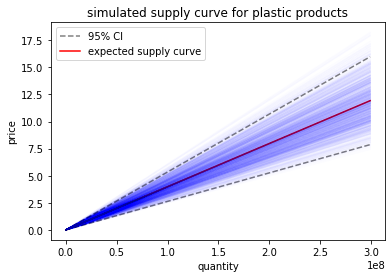

In [204]:
#plot supply curve for US market
slopes = (results['P_US']/ results['Q_US'])
mu = np.mean(slopes)
conf_int = sp.stats.norm.interval(0.95, loc=mu, 
    scale= np.std(slopes))
lb, ub = conf_int
x = np.arange(300000000, step = 1000000)
res = np.ones((3,1)).dot(x.reshape(1,-1))
res = res*np.array([[lb],[mu],[ub]])
yl,ym,yu = res

ax = sns.lineplot(x=x,y=yl,color='grey')
ax = sns.lineplot(x=x,y=ym,color='red')
ax = sns.lineplot(x=x,y=yu,color='grey')

ax.lines[2].set_linestyle("--")
ax.lines[0].set_linestyle("--")
res = np.ones((len(slopes),1)).dot(x.reshape(1,-1))
res = res*(slopes).values.reshape(-1,1)

for i in range(1000):
    y = res[i]
    ax = sns.lineplot(x=x,y=y,color='blue', alpha = 0.01)
plt.legend(['95% CI','expected supply curve'])
plt.ylabel('price')
plt.xlabel('quantity')
plt.title('simulated supply curve for plastic products')
# plt.show()
plt.savefig("figs/simulations/supply_curve.png", dpi=400)

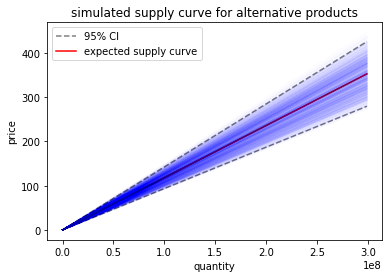

In [205]:
slopes = (results['P1_US']/ results['Q1_US'])
mu = np.mean(slopes)
conf_int = sp.stats.norm.interval(0.95, loc=mu, 
    scale= np.std(slopes))
lb, ub = conf_int
x = np.arange(300000000, step = 1000000)
res = np.ones((3,1)).dot(x.reshape(1,-1))
res = res*np.array([[lb],[mu],[ub]])
yl,ym,yu = res

ax = sns.lineplot(x=x,y=yl,color='grey')
ax = sns.lineplot(x=x,y=ym,color='red')
ax = sns.lineplot(x=x,y=yu,color='grey')

ax.lines[2].set_linestyle("--")
ax.lines[0].set_linestyle("--")
res = np.ones((len(slopes),1)).dot(x.reshape(1,-1))
res = res*(slopes).values.reshape(-1,1)

for i in range(1000):
    y = res[i]
    ax = sns.lineplot(x=x,y=y,color='blue', alpha = 0.01)
plt.legend(['95% CI','expected supply curve'])
plt.ylabel('price')
plt.xlabel('quantity')
plt.title('simulated supply curve for alternative products')
# plt.show()
plt.savefig("figs/simulations/supply_curve1.png", dpi=400)

In [90]:
import numpy as np
from numpy import random
import pandas as pd
from extrapolate_production_data import ProductionData
from Carbon_tariffs import TariffData
from sklearn.model_selection import ParameterGrid
import seaborn as sns
import matplotlib.pyplot as plt

# Import data
## Trade data
trade_flows_country = pd.read_csv("Data/trade_flow_data_all_country.csv")
trade_flows_total = pd.read_csv("Data/trade_flow_data_total.csv")
trade_flows_country = trade_flows_country.rename(
    columns={"qty_in_thousands": "qty_thousands"}
)
trade_flows_total = trade_flows_total.rename(
    columns={"qty_in_thousands": "qty_thousands"}
)

## Carbon tariff data
R = TariffData().get_mean_price()

## Emission data
C_US = ProductionData().get_gwp(product_type="Plastic").to_list()[0]
C_world = C_US * ProductionData().get_ghg_index("world")
C1_US = ProductionData().get_gwp(product_type="Alternative").to_list()[0]
C1_world = C1_US * ProductionData().get_ghg_index("world")

C_IN = C_US * ProductionData().get_ghg_index("india")
C_CN = C_US * ProductionData().get_ghg_index("china")
C_DE = C_US * ProductionData().get_ghg_index("germany")

C1_IN = C1_US * ProductionData().get_ghg_index("india")
C1_CN = C1_US * ProductionData().get_ghg_index("china")
C1_DE = C1_US * ProductionData().get_ghg_index("germany")

P_US = 0.01 * 1000
P_PAP_US = 0.02 * 1000
P_TEX_US = 0.1 * 1000

# Baseline model
## Six unknowns: P_EXP, P1_EXP, P_DOM, P1_DOM, Q, Q1
## Eight parameters: P_US, P1_US, Q_US, Q1_US, R, C_US, C1_US, e1, e2, eta1, eta2

Q_US = trade_flows_total.loc[
    (trade_flows_total["product"] == "plastic bag"),
    "qty_thousands",
].to_list()

Q_PAP_US = trade_flows_total.loc[
    (trade_flows_total["product"] == "paper bag"),
    "qty_thousands",
].to_list()

Q_TEX_US = trade_flows_total.loc[
    (trade_flows_total["product"] == "textile bag"),
    "qty_thousands",
].to_list()

# Set elasticity parameters

N_ITERATION = 10000

params = pd.DataFrame(
    {
        "P_US": P_US
        + random.uniform(
            low=-0.2 * P_US, high=0.2 * P_US, size=N_ITERATION * 10
        ),
        "P_PAP_US": P_PAP_US
        + random.uniform(
            low=-0.2 * P_PAP_US, high=0.2 * P_PAP_US, size=N_ITERATION * 10
        ),
        "P_TEX_US": P_TEX_US
        + random.uniform(
            low=-0.2 * P_TEX_US, high=0.2 * P_TEX_US, size=N_ITERATION * 10
        ),
        "Q_US": random.choice(Q_US, size=N_ITERATION * 10),
        "Q_PAP_US": random.choice(Q_PAP_US, size=N_ITERATION * 10),
        "Q_TEX_US": random.choice(Q_TEX_US, size=N_ITERATION * 10),
        "e1": random.uniform(low=-0.4, high=-0.15, size=N_ITERATION * 10),
        "e2": random.uniform(low=-0.4, high=-0.15, size=N_ITERATION * 10),
        "eta1": random.uniform(low=0.075, high=0.2, size=N_ITERATION * 10),
        "eta2": random.uniform(low=0.075, high=0.2, size=N_ITERATION * 10),
    }
)

params = params.loc[
    (-params["e1"] > params["eta1"]) & (-params["e2"] > params["eta2"])
].sample(N_ITERATION)

## Solution: baseline
def simulation_baseline(
    P_US, P_PAP_US, P_TEX_US, Q_US, Q_PAP_US, Q_TEX_US, e1, e2, eta1, eta2, R=R
):
    Q1_US = Q_PAP_US + Q_TEX_US
    P1_US = np.average([P_PAP_US, P_TEX_US], weights=[Q_PAP_US, Q_TEX_US])
    a = np.array(
        [
            [1, 0, 0, 0, -P_US / Q_US, 0],
            [0, 1, 0, 0, 0, -P1_US / Q1_US],
            [-1, 0, 1, 0, 0, 0],
            [0, -1, 0, 1, 0, 0],
            [0, 0, e1 * Q_US / P_US, eta1 * Q_US / P1_US, -1, 0],
            [0, 0, eta2 * Q1_US / P_US, e2 * Q1_US / P1_US, 0, -1],
        ]
    )
    b = np.array(
        [
            0,
            0,
            R * C_world,
            R * C1_world,
            (e1 + eta1 - 1) * Q_US,
            (e2 + eta2 - 1) * Q1_US,
        ]
    )
    x = np.linalg.solve(a, b)
    return np.concatenate((x, np.array([Q1_US, P1_US])), axis=0)


results = params.apply(
    lambda row: simulation_baseline(
        row["P_US"],
        row["P_PAP_US"],
        row["P_TEX_US"],
        row["Q_US"],
        row["Q_PAP_US"],
        row["Q_TEX_US"],
        row["e1"],
        row["e2"],
        row["eta1"],
        row["eta2"],
    ),
    axis=1,
)

results = pd.DataFrame(results.tolist())
results.columns = [
    "P_EXP",
    "P1_EXP",
    "P_DOM",
    "P1_DOM",
    "Q_DOM",
    "Q1_DOM",
    "Q1_US",
    "P1_US",
]

results = pd.concat(
    [params.reset_index(drop=True), results],
    axis=1,
)


# The ones we are interested in
results.loc[(results["Q_DOM"] > results["Q_US"])]

results.loc[
    (results["Q_DOM"] > results["Q_US"])
    & (results["Q1_DOM"] < results["Q1_US"])
]

results["plastic_change"] = results["Q_DOM"] - results["Q_US"]
results["plastic_proportion_before"] = results["Q_US"] / (
    results["Q_US"] + results["Q1_US"]
)
results["plastic_proportion_after"] = results["Q_DOM"] / (
    results["Q_DOM"] + results["Q1_DOM"]
)
results["plastic_percentage_change"] = (
    results["plastic_proportion_after"] - results["plastic_proportion_before"]
) * 100

results["non_plastic_change"] = results["Q1_DOM"] - results["Q1_US"]

results["CO2_change"] = (
    results["non_plastic_change"] * C1_world
    + results["plastic_change"] * C_world
)

results["current_CO2"] = (
    results["Q1_US"] * C1_world + results["Q_US"] * C_world
)
# Visualizations
## Change in plastic quantity
print(results["plastic_change"].median())
print(results["plastic_change"].median() / results["Q_US"].mean())
print((results["plastic_change"] > 0).mean())

sns.distplot(results["plastic_change"])
plt.axvline(results["plastic_change"].median(), 0, 2, color="red")
plt.xticks([-5*10**6,0,5*10**6,10*10**6,15*10**6, 20*10**6], ['-5M', '0M','5M','10M','15M', '20M'])
plt.savefig("figs/simulations/plastic_increase_amount.png", dpi=400)
# plt.show()
plt.clf()


# Change in non-plastic quantity
print(results["non_plastic_change"].median())
print(results["non_plastic_change"].median() / results["Q1_US"].mean())
print((results["non_plastic_change"] > 0).mean())

sns.distplot(results["non_plastic_change"])
plt.axvline(results["non_plastic_change"].median(), 0, 10, color="red")
plt.xticks([-4*10**6,-3.5*10**6, -3*10**6,-2.5*10**6, -2*10**6,-1.5*10**6, -1*10**6, -0.5*10**6],\
           ['-4M', '-3.5M','-3M','-2.5M', '-2M', '-1.5M','-1M','-0.5M'])
plt.xticks(
    [
        -4 * 10 ** 6,
        -3.5 * 10 ** 6,
        -3 * 10 ** 6,
        -2.5 * 10 ** 6,
        -2 * 10 ** 6,
        -1.5 * 10 ** 6,
        -1 * 10 ** 6,
        -0.5 * 10 ** 6,
    ],
    ["-4M", "-3.5M", "-3M", "-2.5M", "-2M", "-1.5M", "-1M", "-0.5M"],
)
plt.savefig("figs/simulations/non_plastic_increase_amount.png", dpi=400)
# plt.show()
plt.clf()

# Change in plastic bag price
print(results["P_DOM"].median())
print(results["P_EXP"].median())
print(results["P_US"].median())


print(results["P1_DOM"].median())
print(results["P1_EXP"].median())
print(results["P1_US"].median())

np.average(
    [results["P_PAP_US"], results["P_TEX_US"]],
    weights=[results["Q_PAP_US"], results["Q_TEX_US"]],
)

ax = sns.scatterplot(x=results["e1"], y=results["plastic_change"], alpha=0.1)
ax.set(xlabel="e", ylabel="Change in plastic bag import")
plt.yticks(
    [-5 * 10 ** 6, 0, 5 * 10 ** 6, 10 * 10 ** 6, 15 * 10 ** 6, 20 * 10 ** 6],
    ["-5M", "0M", "5M", "10M", "15M", "20M"],
)
# plt.show()
plt.savefig("figs/simulations/plastic_change_e1.png", dpi=400)
plt.clf()


ax = sns.scatterplot(x=results["e2"], y=results["plastic_change"], alpha=0.1)
ax.set(xlabel="e'", ylabel="Change in plastic bag import")
plt.yticks(
    [-5 * 10 ** 6, 0, 5 * 10 ** 6, 10 * 10 ** 6, 15 * 10 ** 6, 20 * 10 ** 6],
    ["-5M", "0M", "5M", "10M", "15M", "20M"],
)
# plt.show()
plt.savefig("figs/simulations/plastic_change_e2.png", dpi=400)
# plt.show()
plt.clf()

ax = sns.scatterplot(x=results["eta1"], y=results["plastic_change"], alpha=0.1)
ax.set(xlabel="eta", ylabel="Change in plastic bag import")
plt.yticks(
    [-5 * 10 ** 6, 0, 5 * 10 ** 6, 10 * 10 ** 6, 15 * 10 ** 6, 20 * 10 ** 6],
    ["-5M", "0M", "5M", "10M", "15M", "20M"],
)
# plt.show()
plt.savefig("figs/simulations/plastic_change_eta1.png", dpi=400)
# plt.show()
plt.clf()

## Change in CO2 emission quantity
print(results["CO2_change"].median())
print((results["CO2_change"] > 0).mean())
print(results["CO2_change"].median() / results["current_CO2"].mean())

sns.distplot(results["CO2_change"])
plt.axvline(results["CO2_change"].median(), 0, 2, color="red")

plt.xticks(
    [-8 * 10 ** 5, -6*10**5, -4*10**5, -2*10**5, 0, 2*10**5],
    ["-800K", "-600K", "-400K", "-200K", "0", "200K"],
)
# plt.show()
plt.savefig("figs/simulations/CO2_change.png", dpi=400)
plt.clf()

# New simulation: change in R

N_ITERATION = 10000

params_new_R = pd.DataFrame(
    {
        "P_US": P_US
        + random.uniform(
            low=-0.2 * P_US, high=0.2 * P_US, size=N_ITERATION * 10
        ),
        "P_PAP_US": P_PAP_US
        + random.uniform(
            low=-0.2 * P_PAP_US, high=0.2 * P_PAP_US, size=N_ITERATION * 10
        ),
        "P_TEX_US": P_TEX_US
        + random.uniform(
            low=-0.2 * P_TEX_US, high=0.2 * P_TEX_US, size=N_ITERATION * 10
        ),
        "Q_US": random.choice(Q_US, size=N_ITERATION * 10),
        "Q_PAP_US": random.choice(Q_PAP_US, size=N_ITERATION * 10),
        "Q_TEX_US": random.choice(Q_TEX_US, size=N_ITERATION * 10),
        "e1": random.uniform(low=-0.4, high=-0.15, size=N_ITERATION * 10),
        "e2": random.uniform(low=-0.4, high=-0.15, size=N_ITERATION * 10),
        "eta1": random.uniform(low=0.075, high=0.2, size=N_ITERATION * 10),
        "eta2": random.uniform(low=0.075, high=0.2, size=N_ITERATION * 10),
        "R": np.linspace(R, 2 * R, num=N_ITERATION * 10),
    }
)

params_new_R = params_new_R.loc[
    (-params_new_R["e1"] > params_new_R["eta1"])
    & (-params_new_R["e2"] > params_new_R["eta2"])
].sample(N_ITERATION)

results_Q_DOM_new_R = params_new_R.apply(
    lambda row: simulation_baseline(
        row["P_US"],
        row["P_PAP_US"],
        row["P_TEX_US"],
        row["Q_US"],
        row["Q_PAP_US"],
        row["Q_TEX_US"],
        row["e1"],
        row["e2"],
        row["eta1"],
        row["eta2"],
        row["R"],
    )[4],
    axis=1,
)

results_new_R = pd.concat(
    [
        params_new_R,
        pd.DataFrame({"Q_DOM": results_Q_DOM_new_R}),
    ],
    axis=1,
)

results_new_R["plastic_change"] = (
    results_new_R["Q_DOM"] - results_new_R["Q_US"]
)

ax = sns.regplot(
    x=results_new_R["R"],
    y=results_new_R["plastic_change"],
    scatter_kws={"alpha": 0.1},
    line_kws={"color": "red"},
)
plt.yticks(
    [-1 * 10 ** 7, 0, 1 * 10 ** 7, 2 * 10 ** 7, 3 * 10 ** 7, 4 * 10 ** 7],
    ["-10M", "0M", "10M", "20M", "30M", "40M"],
)
plt.xticks(
    [70, 80, 90, 100, 110, 120], ["70%", "80%", "90%", "100%", "110%", "120%"]
)
# plt.show()
plt.savefig("figs/simulations/plastic_change_R.png", dpi=400)
plt.clf()

['Austria' 'Belgium' 'Bulgaria' 'China' 'Croatia' 'Cyprus'
 'Czech Republic' 'Denmark' 'Estonia' 'Finland' 'France' 'Germany'
 'Greece' 'Hungary' 'India' 'Ireland' 'Italy' 'Latvia' 'Lithuania'
 'Luxembourg' 'Netherlands' 'Poland' 'Portugal' 'Romania' 'Slovakia'
 'Slovenia' 'Spain' 'Sweden']
     Country      product  Year  qty_thousands  price_per_thousands  \
233  Germany  textile bag  2018       0.087540              6080.00   
234  Germany    paper bag  2018    1159.617323               232.41   
235  Germany  plastic bag  2018    1497.330000                23.90   

     US_inflation_adjusted_price country_category  
233                  6419.080519               EU  
234                   245.371464               EU  
235                    25.232899               EU  
['Austria' 'Belgium' 'Bulgaria' 'China' 'Croatia' 'Cyprus'
 'Czech Republic' 'Denmark' 'Estonia' 'Finland' 'France' 'Germany'
 'Greece' 'Hungary' 'India' 'Ireland' 'Italy' 'Latvia' 'Lithuania'
 'Luxembourg' 'Netherl

C:\Users\yzp60\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-2170729.113405375
-0.11179491247181804
0.0


C:\Users\yzp60\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


11.572803903478846
10.199846789157682
9.991274536204928
33.52928839431732
20.11236049253654
22.646045231424615
-361680.85815899505
0.0183
-0.03652012213879856


C:\Users\yzp60\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

In [92]:
results.keys()

Index(['P_US', 'P_PAP_US', 'P_TEX_US', 'Q_US', 'Q_PAP_US', 'Q_TEX_US', 'e1',
       'e2', 'eta1', 'eta2', 'P_EXP', 'P1_EXP', 'P_DOM', 'P1_DOM', 'Q_DOM',
       'Q1_DOM', 'Q1_US', 'P1_US', 'plastic_change',
       'plastic_proportion_before', 'plastic_proportion_after',
       'plastic_percentage_change', 'non_plastic_change', 'CO2_change',
       'current_CO2'],
      dtype='object')

[Text(0.5, 0, 'eta'), Text(0, 0.5, 'Change in plastic bag import')]

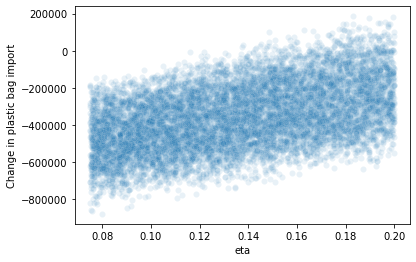

In [94]:
ax = sns.scatterplot(x=results["eta1"], y=results["CO2_change"], alpha=0.1)
ax.set(xlabel="eta", ylabel="Change in plastic bag import")

In [86]:
import numpy as np
from numpy import random
import pandas as pd
from extrapolate_production_data import ProductionData
from Carbon_tariffs import TariffData
from sklearn.model_selection import ParameterGrid
import seaborn as sns
import matplotlib.pyplot as plt

# Import data
## Trade data
trade_flows_country = pd.read_csv("Data/trade_flow_data_all_country.csv")
trade_flows_total = pd.read_csv("Data/trade_flow_data_total.csv")

### Get income levels of countries
income_level_Data = pd.read_csv("Data/country_level.csv")[
    ["country_name", "income_id"]
]
income_level_Data.loc[
    income_level_Data["country_name"] == "Bosnia and Herzegovina",
    "country_name",
] = "Bosnia-Herzegov"
income_level_Data.loc[
    income_level_Data["country_name"] == "Myanmar", "country_name"
] = "Burma"
income_level_Data.loc[
    income_level_Data["country_name"] == "Dominican Republic", "country_name"
] = "Dominican Rep"
income_level_Data.loc[
    income_level_Data["country_name"] == "Egypt, Arab Rep.", "country_name"
] = "Egypt"
income_level_Data.loc[
    income_level_Data["country_name"] == "Hong Kong SAR, China", "country_name"
] = "Hong Kong"
income_level_Data.loc[
    income_level_Data["country_name"] == "Lao PDR", "country_name"
] = "Laos"
income_level_Data.loc[
    income_level_Data["country_name"] == "Russian Federation", "country_name"
] = "Russia"
income_level_Data.loc[
    income_level_Data["country_name"] == "Slovak Republic", "country_name"
] = "Slovakia"
income_level_Data.loc[
    income_level_Data["country_name"] == "Korea, Rep.", "country_name"
] = "South Korea"
income_level_Data.loc[
    income_level_Data["country_name"] == "United Arab Emirates", "country_name"
] = "United Arab Em"
income_level_Data.loc[
    income_level_Data["country_name"] == "Venezuela, RB", "country_name"
] = "Venezuela"

trade_flows_country = pd.merge(
    trade_flows_country,
    income_level_Data,
    how="left",
    left_on="Country",
    right_on="country_name",
)
trade_flows_country.loc[
    trade_flows_country["Country"] == "Taiwan", "income_id"
] = "HIC"

## Carbon tariff data
R = TariffData().get_mean_price()

## Emission data
C_US = ProductionData().get_gwp(product_type="Plastic").to_list()[0]
C_world = C_US * ProductionData().get_ghg_index("world")
C1_US = ProductionData().get_gwp(product_type="Alternative").to_list()[0]
C1_world = C1_US * ProductionData().get_ghg_index("world")

C_IN = C_US * ProductionData().get_ghg_index("india")
C_CN = C_US * ProductionData().get_ghg_index("china")
C_DE = C_US * ProductionData().get_ghg_index("germany")

C1_IN = C1_US * ProductionData().get_ghg_index("india")
C1_CN = C1_US * ProductionData().get_ghg_index("china")
C1_DE = C1_US * ProductionData().get_ghg_index("germany")

P_US = 0.01 * 1000
P_PAP_US = 0.02 * 1000
P_TEX_US = 0.1 * 1000


# Aggregate data by income levels
pd.DataFrame(
    trade_flows_country.loc[
        (trade_flows_country["product"] == "plastic bag")
        & (trade_flows_country["income_id"].isin(["LMC", "LIC"])),
    ]
    .groupby(["Year"])
    .agg(
        sum_qty_in_thousands=pd.NamedAgg(
            column="qty_in_thousands", aggfunc=sum
        )
    )
)
# Three-country model
## 14 unknowns: P_LIC, P1_LIC, P_MIC, P1_MIC, P_HIC, P1_HIC, P_DOM, P1_DOM, Q_LIC, Q1_LIC, Q_MIC, Q1_MIC, Q_HIC, Q1_HIC
## Eight parameters: P_US, P1_US, Q_IN, Q1_IN, Q_CN, Q1_CN, Q_DE, Q1_DE, R, C_IN, C1_IN, C_CN, C1_CN, C_DE, C1_DE, e1, e2, eta1, eta2

# Stuff below needs to change to include all countries
Q_US = trade_flows_total.loc[
    (trade_flows_total["product"] == "plastic bag"),
    "qty_in_thousands",
].to_list()

Q_IN = pd.DataFrame(
    trade_flows_country.loc[
        (trade_flows_country["product"] == "plastic bag")
        & (trade_flows_country["income_id"].isin(["LMC", "LIC"])),
    ]
    .groupby(["Year"])
    .agg(
        sum_qty_in_thousands=pd.NamedAgg(
            column="qty_in_thousands", aggfunc=sum
        )
    )
)["sum_qty_in_thousands"].tolist()

Q_PAP_IN = pd.DataFrame(
    trade_flows_country.loc[
        (trade_flows_country["product"] == "paper bag")
        & (trade_flows_country["income_id"].isin(["LMC", "LIC"])),
    ]
    .groupby(["Year"])
    .agg(
        sum_qty_in_thousands=pd.NamedAgg(
            column="qty_in_thousands", aggfunc=sum
        )
    )
)["sum_qty_in_thousands"].tolist()

Q_TEX_IN = pd.DataFrame(
    trade_flows_country.loc[
        (trade_flows_country["product"] == "textile bag")
        & (trade_flows_country["income_id"].isin(["LMC", "LIC"])),
    ]
    .groupby(["Year"])
    .agg(
        sum_qty_in_thousands=pd.NamedAgg(
            column="qty_in_thousands", aggfunc=sum
        )
    )
)["sum_qty_in_thousands"].tolist()

Q_CN = pd.DataFrame(
    trade_flows_country.loc[
        (trade_flows_country["product"] == "plastic bag")
        & (trade_flows_country["income_id"] == "UMC"),
    ]
    .groupby(["Year"])
    .agg(
        sum_qty_in_thousands=pd.NamedAgg(
            column="qty_in_thousands", aggfunc=sum
        )
    )
)["sum_qty_in_thousands"].tolist()

Q_PAP_CN = pd.DataFrame(
    trade_flows_country.loc[
        (trade_flows_country["product"] == "paper bag")
        & (trade_flows_country["income_id"] == "UMC"),
    ]
    .groupby(["Year"])
    .agg(
        sum_qty_in_thousands=pd.NamedAgg(
            column="qty_in_thousands", aggfunc=sum
        )
    )
)["sum_qty_in_thousands"].tolist()

Q_TEX_CN = pd.DataFrame(
    trade_flows_country.loc[
        (trade_flows_country["product"] == "textile bag")
        & (trade_flows_country["income_id"] == "UMC"),
    ]
    .groupby(["Year"])
    .agg(
        sum_qty_in_thousands=pd.NamedAgg(
            column="qty_in_thousands", aggfunc=sum
        )
    )
)["sum_qty_in_thousands"].tolist()

Q_DE = pd.DataFrame(
    trade_flows_country.loc[
        (trade_flows_country["product"] == "plastic bag")
        & (trade_flows_country["income_id"] == "HIC"),
    ]
    .groupby(["Year"])
    .agg(
        sum_qty_in_thousands=pd.NamedAgg(
            column="qty_in_thousands", aggfunc=sum
        )
    )
)["sum_qty_in_thousands"].tolist()

Q_PAP_DE = pd.DataFrame(
    trade_flows_country.loc[
        (trade_flows_country["product"] == "paper bag")
        & (trade_flows_country["income_id"] == "HIC"),
    ]
    .groupby(["Year"])
    .agg(
        sum_qty_in_thousands=pd.NamedAgg(
            column="qty_in_thousands", aggfunc=sum
        )
    )
)["sum_qty_in_thousands"].tolist()

Q_TEX_DE = pd.DataFrame(
    trade_flows_country.loc[
        (trade_flows_country["product"] == "textile bag")
        & (trade_flows_country["income_id"] == "HIC"),
    ]
    .groupby(["Year"])
    .agg(
        sum_qty_in_thousands=pd.NamedAgg(
            column="qty_in_thousands", aggfunc=sum
        )
    )
)["sum_qty_in_thousands"].tolist()

## Solution: Three country
def simulation_threecountry(
    P_US,
    P_PAP_US,
    P_TEX_US,
    Q_IN,
    Q_PAP_IN,
    Q_TEX_IN,
    Q_CN,
    Q_PAP_CN,
    Q_TEX_CN,
    Q_DE,
    Q_PAP_DE,
    Q_TEX_DE,
    e1,
    e2,
    eta1,
    eta2,
):
    Q_US = Q_IN + Q_CN + Q_DE
    Q_PAP_US = Q_PAP_IN + Q_PAP_CN + Q_PAP_DE
    Q_TEX_US = Q_TEX_IN + Q_TEX_CN + Q_TEX_DE
    Q1_IN = Q_PAP_IN + Q_TEX_IN
    Q1_CN = Q_PAP_CN + Q_TEX_CN
    Q1_DE = Q_PAP_DE + Q_TEX_DE
    Q1_US = Q1_IN + Q1_CN + Q1_DE
    P1_US = np.average([P_PAP_US, P_TEX_US], weights=[Q_PAP_US, Q_TEX_US])
    a = np.array(
        [
            [1, 0, 0, 0, 0, 0, 0, 0, -P_US / Q_IN, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, -P1_US / Q1_IN, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -P_US / Q_CN, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -P1_US / Q1_CN, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -P_US / Q_DE, 0],
            [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -P1_US / Q1_DE],
            [-1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, -1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 0, 0],
            [
                0,
                0,
                0,
                0,
                0,
                0,
                e1 * Q_US / P_US,
                eta1 * Q_US / P1_US,
                -1,
                0,
                -1,
                0,
                -1,
                0,
            ],
            [
                0,
                0,
                0,
                0,
                0,
                0,
                eta2 * Q1_US / P_US,
                e2 * Q1_US / P1_US,
                0,
                -1,
                0,
                -1,
                0,
                -1,
            ],
        ]
    )
    b = np.array(
        [
            0,
            0,
            0,
            0,
            0,
            0,
            R * C_IN,
            R * C1_IN,
            R * C_CN,
            R * C1_CN,
            R * C_DE,
            R * C1_DE,
            (e1 + eta1 - 1) * Q_US,
            (e2 + eta2 - 1) * Q1_US,
        ]
    )
    x = np.linalg.solve(a, b)
    return np.concatenate((x, np.array([Q_US, Q1_US, P1_US])), axis=0)


N_ITERATION = 10000

params = pd.DataFrame(
    {
        "P_US": P_US
        + random.uniform(
            low=-0.2 * P_US, high=0.2 * P_US, size=N_ITERATION * 10
        ),
        "P_PAP_US": P_PAP_US
        + random.uniform(
            low=-0.2 * P_PAP_US, high=0.2 * P_PAP_US, size=N_ITERATION * 10
        ),
        "P_TEX_US": P_TEX_US
        + random.uniform(
            low=-0.2 * P_TEX_US, high=0.2 * P_TEX_US, size=N_ITERATION * 10
        ),
        "Q_IN": random.choice(Q_IN, size=N_ITERATION * 10),
        "Q_PAP_IN": random.choice(Q_PAP_IN, size=N_ITERATION * 10),
        "Q_TEX_IN": random.choice(Q_TEX_IN, size=N_ITERATION * 10),
        "Q_CN": random.choice(Q_CN, size=N_ITERATION * 10),
        "Q_PAP_CN": random.choice(Q_PAP_CN, size=N_ITERATION * 10),
        "Q_TEX_CN": random.choice(Q_TEX_CN, size=N_ITERATION * 10),
        "Q_DE": random.choice(Q_DE, size=N_ITERATION * 10),
        "Q_PAP_DE": random.choice(Q_PAP_DE, size=N_ITERATION * 10),
        "Q_TEX_DE": random.choice(Q_TEX_DE, size=N_ITERATION * 10),
        "e1": random.uniform(low=-0.4, high=-0.15, size=N_ITERATION * 10),
        "e2": random.uniform(low=-0.4, high=-0.15, size=N_ITERATION * 10),
        "eta1": random.uniform(low=0.075, high=0.2, size=N_ITERATION * 10),
        "eta2": random.uniform(low=0.075, high=0.2, size=N_ITERATION * 10),
    }
)

params = params.loc[
    (-params["e1"] > params["eta1"]) & (-params["e2"] > params["eta2"])
].sample(N_ITERATION)

simulation_threecountry(
    P_US=P_US,
    P_PAP_US=P_PAP_US,
    P_TEX_US=P_TEX_US,
    Q_IN=Q_IN[0],
    Q_PAP_IN=Q_PAP_IN[0],
    Q_TEX_IN=Q_TEX_IN[0],
    Q_CN=Q_CN[0],
    Q_PAP_CN=Q_PAP_CN[0],
    Q_TEX_CN=Q_TEX_CN[0],
    Q_DE=Q_DE[0],
    Q_PAP_DE=Q_PAP_DE[0],
    Q_TEX_DE=Q_TEX_DE[0],
    e1=-0.4,
    e2=-0.4,
    eta1=0.2,
    eta2=0.2,
)

results = params.apply(
    lambda row: simulation_threecountry(
        P_US=row["P_US"],
        P_PAP_US=row["P_PAP_US"],
        P_TEX_US=row["P_TEX_US"],
        Q_IN=row["Q_IN"],
        Q_PAP_IN=row["Q_PAP_IN"],
        Q_TEX_IN=row["Q_TEX_IN"],
        Q_CN=row["Q_CN"],
        Q_PAP_CN=row["Q_PAP_CN"],
        Q_TEX_CN=row["Q_TEX_CN"],
        Q_DE=row["Q_DE"],
        Q_PAP_DE=row["Q_PAP_DE"],
        Q_TEX_DE=row["Q_TEX_DE"],
        e1=row["e1"],
        e2=row["e2"],
        eta1=row["eta1"],
        eta2=row["eta2"],
    ),
    axis=1,
)

results = pd.DataFrame(results.tolist())
results.columns = [
    "P_LIC",
    "P1_LIC",
    "P_MIC",
    "P1_MIC",
    "P_HIC",
    "P1_HIC",
    "P_DOM",
    "P1_DOM",
    "Q_LIC",
    "Q1_LIC",
    "Q_MIC",
    "Q1_MIC",
    "Q_HIC",
    "Q1_HIC",
    "Q_US",
    "Q1_US",
    "P1_US",
]

results = pd.concat(
    [params.reset_index(drop=True), results],
    axis=1,
)

results["Q_DOM"] = results["Q_LIC"] + results["Q_MIC"] + results["Q_HIC"]
results["Q1_DOM"] = results["Q1_LIC"] + results["Q1_MIC"] + results["Q1_HIC"]

results.loc[(results["Q_DOM"] > results["Q_US"])]

results.loc[
    (results["Q_DOM"] > results["Q_US"])
    & (results["Q1_DOM"] < results["Q1_US"])
]

results["plastic_change"] = results["Q_DOM"] - results["Q_US"]
results["plastic_proportion_before"] = results["Q_US"] / (
    results["Q_US"] + results["Q1_US"]
)
results["plastic_proportion_after"] = results["Q_DOM"] / (
    results["Q_DOM"] + results["Q1_DOM"]
)
results["plastic_percentage_change"] = (
    results["plastic_proportion_after"] - results["plastic_proportion_before"]
) * 100

results["non_plastic_change"] = results["Q1_DOM"] - results["Q1_US"]

# Visualizations
## Change in plastic quantity
print(results["plastic_change"].median())
print(results["plastic_change"].median() / results["Q_US"].mean())
print((results["plastic_change"] > 0).mean())

sns.distplot(results["plastic_change"])
plt.axvline(results["plastic_change"].median(), 0, 2, color="red")
plt.xticks([-10*10**6,-5*10**6,0,5*10**6,10*10**6,15*10**6, 20*10**6,25*10**6], ['-10M','-5M','0M','5M','10M','15M','20M','25M'])
# plt.show()
plt.savefig("figs/simulations/plastic_increase_amount_3c.png", dpi=400)
plt.clf()

# Change in non-plastic quantity
print(results["non_plastic_change"].median())
print(results["non_plastic_change"].median() / results["Q1_US"].mean())
print((results["non_plastic_change"] > 0).mean())

sns.distplot(results["non_plastic_change"])
plt.axvline(results["non_plastic_change"].median(), 0, 10, color="red")
plt.xticks([-4*10**6,-3.5*10**6, -3*10**6,-2.5*10**6, -2*10**6,-1.5*10**6, -1*10**6, -0.5*10**6],\
           ['-4M', '-3.5M','-3M','-2.5M', '-2M', '-1.5M','-1M','-0.5M'])
plt.savefig("figs/simulations/non_plastic_increase_amount_3c.png", dpi=400)
# plt.show()
plt.clf()

# Change in plastic bag price
print(results["P_DOM"].median())
print(results["P_US"].median())

# Change in non-plastic bag price
print(results["P1_DOM"].median())
print(results["P1_US"].median())

## Change in plastic quantity: LIC
results["plastic_change_LIC"] = results["Q_LIC"] - results["Q_IN"]
print(results["plastic_change_LIC"].median())
print(results["plastic_change_LIC"].median() / results["Q_IN"].mean())
print((results["plastic_change_LIC"] > 0).mean())

sns.distplot(results["plastic_change_LIC"])
plt.axvline(results["plastic_change_LIC"].median(), 0, 2, color="red")
plt.xticks([-4*10**6, -2*10**6,0, 2*10**6,4*10**6],\
           ['-4M', '-2M','0','2M', '4M'])
plt.savefig("figs/simulations/plastic_increase_amount_LIC.png", dpi=400)
# plt.show()
plt.clf()

results["P_change_LIC"] = results["P_LIC"] - results["P_US"]
print(results["P_change_LIC"].median())
print(results["P_change_LIC"].median() / results["P_US"].mean())
print((results["P_change_LIC"] > 0).mean())

sns.distplot(results["P_change_LIC"])
plt.axvline(results["P_change_LIC"].median(), 0, 2, color="red")
plt.xlabel("Price change (LIC)")
plt.xticks([-0.9, -0.6,-0.3,0, 0.3,0.6],\
           ['-0.9USD', '-0.6USD', '-0.3USD','0USD','+0.3USD', '+0.6USD'])
plt.savefig("figs/simulations/P_increase_amount_LIC.png", dpi=400)
# plt.show()
plt.clf()

## Change in plastic quantity: MIC
results["plastic_change_MIC"] = results["Q_MIC"] - results["Q_CN"]
print(results["plastic_change_MIC"].median())
print(results["plastic_change_MIC"].median() / results["Q_IN"].mean())
print((results["plastic_change_MIC"] > 0).mean())

sns.distplot(results["plastic_change_MIC"])
plt.axvline(results["plastic_change_MIC"].median(), 0, 2, color="red")
plt.xticks([-10*10**6, -5*10**6,0, 5*10**6,10*10**6, 15*10**6],\
           ['-10M', '-5M','0','5M', '10M','15M'])
plt.savefig("figs/simulations/plastic_increase_amount_MIC.png", dpi=400)
# plt.show()
plt.clf()

results["P_change_MIC"] = results["P_MIC"] - results["P_US"]
print(results["P_change_MIC"].median())
print(results["P_change_MIC"].median() / results["P_US"].mean())
print((results["P_change_MIC"] > 0).mean())

sns.distplot(results["P_change_MIC"])
plt.axvline(results["P_change_MIC"].median(), 0, 2, color="red")
plt.xlabel("Price change (MIC)")
plt.xticks([-1,-0.5,0,0.5,1],\
           [ '-1USD', '-0.5USD','0USD','+0.5USD', '+1USD'])
plt.savefig("figs/simulations/P_increase_amount_MIC.png", dpi=400)
# plt.show()
plt.clf()

## Change in plastic quantity: HIC
results["plastic_change_HIC"] = results["Q_HIC"] - results["Q_DE"]
print(results["plastic_change_HIC"].median())
print(results["plastic_change_HIC"].median() / results["Q_IN"].mean())
print((results["plastic_change_HIC"] > 0).mean())

sns.distplot(results["plastic_change_HIC"])
plt.axvline(results["plastic_change_HIC"].median(), 0, 2, color="red")
plt.xticks([-2*10**6,0, 2*10**6,4*10**6, 6*10**6,8*10**6, 10*10**6, 12*10**6],\
           ['-2M', '0','2M','4M', '6M','8M','10M','12M'])
plt.savefig("figs/simulations/plastic_increase_amount_HIC.png", dpi=400)
# plt.show()
plt.clf()

results["P_change_HIC"] = results["P_HIC"] - results["P_US"]
print(results["P_change_HIC"].median())
print(results["P_change_HIC"].median() / results["P_US"].mean())
print((results["P_change_HIC"] > 0).mean())

sns.distplot(results["P_change_HIC"])
plt.axvline(results["P_change_HIC"].median(), 0, 2, color="red")
plt.xlabel("Price change (HIC)")
plt.xticks([-0.4,0,0.4,0.8, 1.2,1.6],\
           ['-0.4USD', '0USD', '+0.4USD','+0.8USD','+1.2USD', '+1.6USD'])
plt.savefig("figs/simulations/P_increase_amount_HIC.png", dpi=400)
# plt.show()
plt.clf()

## Change in non-plastic quantity: LIC
results["non_plastic_change_LIC"] = (
    results["Q1_LIC"] - results["Q_PAP_IN"] - results["Q_TEX_IN"]
)
print(results["non_plastic_change_LIC"].median())
print(
    results["non_plastic_change_LIC"].median()
    / (results["Q_PAP_IN"].mean() + results["Q_TEX_IN"].mean())
)
print((results["non_plastic_change_LIC"] > 0).mean())

sns.distplot(results["non_plastic_change_LIC"])
plt.axvline(results["non_plastic_change_LIC"].median(), 0, 2, color="red")
plt.xticks([-8*10**5, -6*10**5,-4*10**5,-2*10**5,0*10**5],\
           ['-800K', '-600K', '-400K','-200K','0K'])
plt.savefig("figs/simulations/non_plastic_increase_amount_LIC.png", dpi=400)
# plt.show()
plt.clf()

results["P1_change_LIC"] = results["P1_LIC"] - results["P1_US"]
print(results["P1_change_LIC"].median())
print(results["P1_change_LIC"].median() / results["P_US"].mean())
print((results["P1_change_LIC"] > 0).mean())

sns.distplot(results["P1_change_LIC"])
plt.axvline(results["P1_change_LIC"].median(), 0, 2, color="red")
plt.xlabel("Price change (LIC)")
plt.xticks([-9,-8,-7,-6,-5],\
           ['-9USD', '-8USD', '-7USD','-6USD','-5USD'])
plt.savefig("figs/simulations/P1_increase_amount_LIC.png", dpi=400)
# plt.show()
plt.clf()

## Change in non-plastic quantity: MIC
results["non_plastic_change_MIC"] = (
    results["Q1_MIC"] - results["Q_PAP_CN"] - results["Q_TEX_CN"]
)
print(results["non_plastic_change_MIC"].median())
print(
    results["non_plastic_change_MIC"].median()
    / (results["Q_PAP_CN"].mean() + results["Q_TEX_CN"].mean())
)
print((results["non_plastic_change_MIC"] > 0).mean())

sns.distplot(results["non_plastic_change_MIC"])
plt.axvline(results["non_plastic_change_MIC"].median(), 0, 2, color="red")
plt.xticks([-3*10**6,-2.5*10**6,-2*10**6,-1.5*10**6,-1*10**6],\
          ['-3M','-2.5M','-2M','-1.5M','-1M'])
plt.savefig("figs/simulations/non_plastic_increase_amount_MIC.png", dpi=400)
# plt.show()
plt.clf()

results["P1_change_MIC"] = results["P1_MIC"] - results["P1_US"]
print(results["P1_change_MIC"].median())
print(results["P1_change_MIC"].median() / results["P_US"].mean())
print((results["P1_change_MIC"] > 0).mean())

sns.distplot(results["P1_change_MIC"])
plt.axvline(results["P1_change_MIC"].median(), 0, 2, color="red")
plt.xticks([-7,-6,-5,-4,-3],\
          ['-7USD','-6USD','-5USD','-4USD','-3USD'])
plt.xlabel("Price change (MIC)")
plt.savefig("figs/simulations/P1_increase_amount_MIC.png", dpi=400)
# plt.show()
plt.clf()

## Change in non-plastic quantity: HIC
results["non_plastic_change_HIC"] = (
    results["Q1_HIC"] - results["Q_PAP_DE"] - results["Q_TEX_DE"]
)
print(results["non_plastic_change_HIC"].median())
print(
    results["non_plastic_change_HIC"].median()
    / (results["Q_PAP_DE"].mean() + results["Q_TEX_DE"].mean())
)
print((results["non_plastic_change_HIC"] > 0).mean())

sns.distplot(results["non_plastic_change_HIC"])
plt.axvline(results["non_plastic_change_HIC"].median(), 0, 2, color="red")
plt.xticks([-1.5*10**6,-1*10**6,-0.5*10**6,0*10**6,0.5*10**6, 1*10**6],\
          ['-1.5M','-1M','-0.5M','0M','0.5M','1M'])
plt.savefig("figs/simulations/non_plastic_increase_amount_HIC.png", dpi=400)
# plt.show()
plt.clf()

results["P1_change_HIC"] = results["P1_HIC"] - results["P1_US"]
print(results["P1_change_HIC"].median())
print(results["P1_change_HIC"].median() / results["P_US"].mean())
print((results["P1_change_HIC"] > 0).mean())

sns.distplot(results["P1_change_HIC"])
plt.axvline(results["P1_change_HIC"].median(), 0, 2, color="red")
plt.xlabel("Price change (HIC)")
plt.xticks([-2,-1,-0,1,2],\
          ['-2USD','-1USD','0USD','+1USD','+2USD'])
plt.savefig("figs/simulations/P1_increase_amount_HIC.png", dpi=400)
# plt.show()
plt.clf()


# sns.distplot(results["plastic_change"])
# plt.axvline(results["plastic_change"].median(), 0, 2, color="red")
# plt.xticks([-10*10**6,-5*10**6,0,5*10**6,10*10**6,15*10**6, 20*10**6,25*10**6], ['-10M','-5M','0M','5M','10M','15M','20M','25M'])
# # plt.show()
# plt.savefig("figs/simulations/plastic_increase_amount_3c.png", dpi=400)
# plt.clf()

['Austria' 'Belgium' 'Bulgaria' 'China' 'Croatia' 'Cyprus'
 'Czech Republic' 'Denmark' 'Estonia' 'Finland' 'France' 'Germany'
 'Greece' 'Hungary' 'India' 'Ireland' 'Italy' 'Latvia' 'Lithuania'
 'Luxembourg' 'Netherlands' 'Poland' 'Portugal' 'Romania' 'Slovakia'
 'Slovenia' 'Spain' 'Sweden']
     Country      product  Year  qty_thousands  price_per_thousands  \
233  Germany  textile bag  2018       0.087540              6080.00   
234  Germany    paper bag  2018    1159.617323               232.41   
235  Germany  plastic bag  2018    1497.330000                23.90   

     US_inflation_adjusted_price country_category  
233                  6419.080519               EU  
234                   245.371464               EU  
235                    25.232899               EU  
['Austria' 'Belgium' 'Bulgaria' 'China' 'Croatia' 'Cyprus'
 'Czech Republic' 'Denmark' 'Estonia' 'Finland' 'France' 'Germany'
 'Greece' 'Hungary' 'India' 'Ireland' 'Italy' 'Latvia' 'Lithuania'
 'Luxembourg' 'Netherl

C:\Users\yzp60\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-2224824.401510792
-0.11570254331295314
0.0


C:\Users\yzp60\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


11.823126700416493
10.01008055460154
34.202465246969396
22.6682823896234
-374910.4476821516
-0.012364295561277227
0.2621


C:\Users\yzp60\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-0.13702945437432223
-0.013714157517193187
0.2621


C:\Users\yzp60\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


1454911.9763436466
0.04798202291339141
0.6722


C:\Users\yzp60\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.09179673134587585
0.009187184164083727
0.6722


C:\Users\yzp60\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


3372313.418451391
0.11121663877007824
1.0


C:\Users\yzp60\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.5748742345329498
0.05753446104677835
1.0


C:\Users\yzp60\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-314351.9927723984
-0.29383347528303744
0.0


C:\Users\yzp60\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-7.472124352168925
-0.7478238224153813
0.0


C:\Users\yzp60\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-1622294.9741088182
-0.22958583003051722
0.0


C:\Users\yzp60\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-5.235969701872106
-0.5240253898302095
0.0


C:\Users\yzp60\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-253631.28747845115
-0.022864460176479195
0.2715


C:\Users\yzp60\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-0.5151987734677768
-0.0515620321504091
0.2715


C:\Users\yzp60\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

In [75]:
results["P_change_LIC"]

0      -0.143727
1      -0.522615
2       0.042812
3      -0.070258
4      -0.241717
          ...   
9995   -0.102881
9996   -0.267903
9997    0.225465
9998   -0.032916
9999    0.239905
Name: P_change_LIC, Length: 10000, dtype: float64

In [97]:
results

,P_US,P_PAP_US,P_TEX_US,Q_US,Q_PAP_US,Q_TEX_US,e1,e2,eta1,eta2,...,Q1_DOM,Q1_US,P1_US,plastic_change,plastic_proportion_before,plastic_proportion_after,plastic_percentage_change,non_plastic_change,CO2_change,current_CO2
0,8.112233,22.310465,94.632934,2.527668e+08,1.807676e+07,561583.306173,-0.228013,-0.245273,0.176303,0.080820,...,1.687251e+07,1.863835e+07,24.489579,8.500190e+06,0.931326,0.939338,0.801147,-1.765834e+06,-196434.090001,9.756729e+06
1,9.816630,19.610018,113.724304,2.746139e+08,1.917832e+07,631313.901661,-0.376093,-0.375000,0.199070,0.080346,...,1.679512e+07,1.980963e+07,22.609350,7.032320e+06,0.932717,0.943724,1.100665,-3.014509e+06,-503114.517074,1.050363e+07
2,10.671144,18.750791,105.986256,2.964212e+08,1.825672e+07,614972.204430,-0.207052,-0.374486,0.121107,0.085588,...,1.585663e+07,1.887169e+07,21.593534,7.185558e+06,0.940146,0.950365,1.021929,-3.015065e+06,-499798.561277,1.078723e+07
3,8.576889,16.861522,100.654513,1.941517e+08,1.917832e+07,614972.204430,-0.175087,-0.334499,0.080861,0.161178,...,1.678761e+07,1.979329e+07,19.464947,2.549369e+06,0.907484,0.921365,1.388116,-3.005686e+06,-601751.106244,8.694951e+06
4,11.798252,21.378648,108.328158,2.527668e+08,1.825672e+07,619411.099656,-0.265578,-0.334345,0.156949,0.199390,...,1.666945e+07,1.887613e+07,24.231853,7.519207e+06,0.930511,0.939812,0.930055,-2.206677e+06,-315088.606818,9.808859e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9.333340,17.524016,118.141209,2.746139e+08,1.921854e+07,561583.306173,-0.203139,-0.327895,0.171736,0.178384,...,1.708767e+07,1.978012e+07,20.380669,1.364877e+07,0.932811,0.944039,1.122841,-2.692450e+06,-284074.586090,1.049716e+07
9996,11.319958,19.349907,99.018272,2.527668e+08,1.921854e+07,619411.099656,-0.365120,-0.199655,0.171408,0.132983,...,1.815101e+07,1.983795e+07,21.837436,8.601358e+06,0.927228,0.935063,0.783528,-1.686938e+06,-176867.757891,1.001972e+07
9997,8.001715,21.665757,91.845995,1.960739e+08,1.852281e+07,619411.099656,-0.383014,-0.199478,0.078009,0.186718,...,1.781005e+07,1.914222e+07,23.936676,-3.887685e+06,0.911056,0.915189,0.413289,-1.332166e+06,-379270.877473,8.595339e+06
9998,11.128567,21.168016,88.530466,2.964212e+08,1.917832e+07,631313.901661,-0.299342,-0.393704,0.087896,0.101245,...,1.676703e+07,1.980963e+07,23.314793,3.443143e+04,0.937357,0.946469,0.911224,-3.042600e+06,-666264.392368,1.099286e+07
